  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Load Data


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.34it/s]


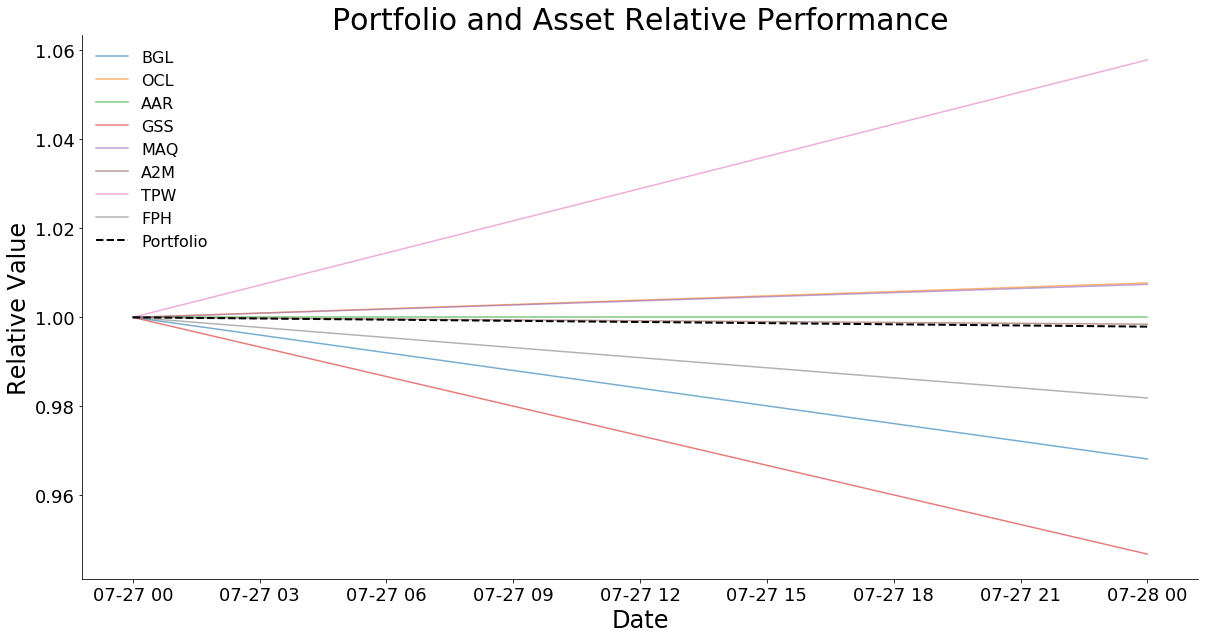

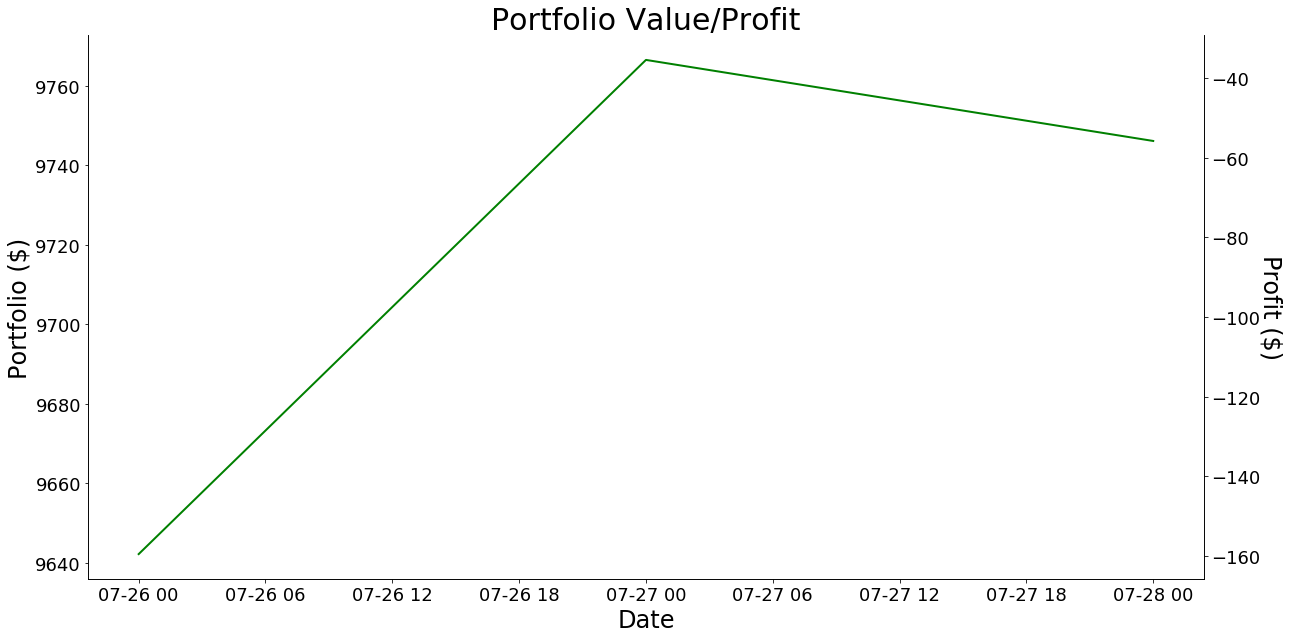

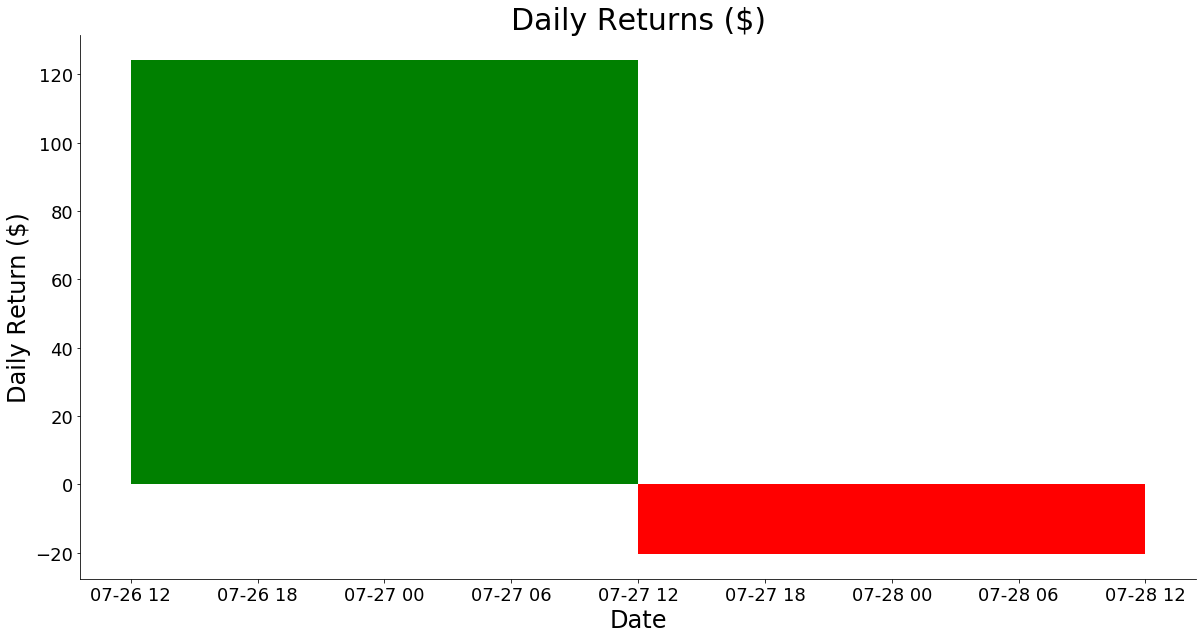

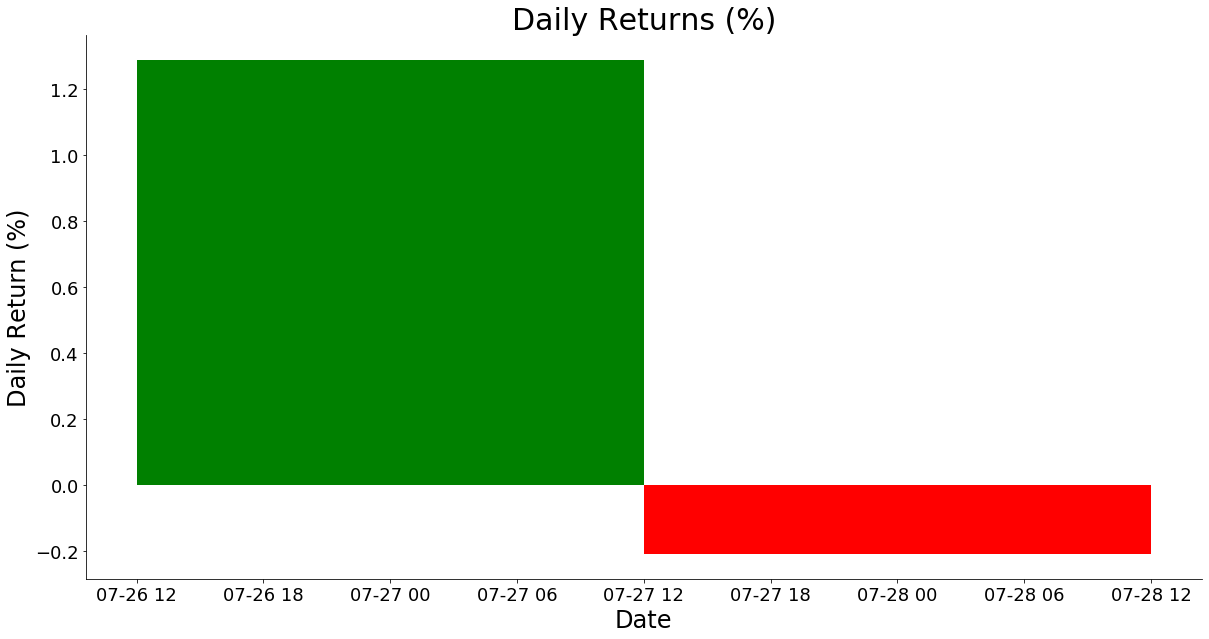

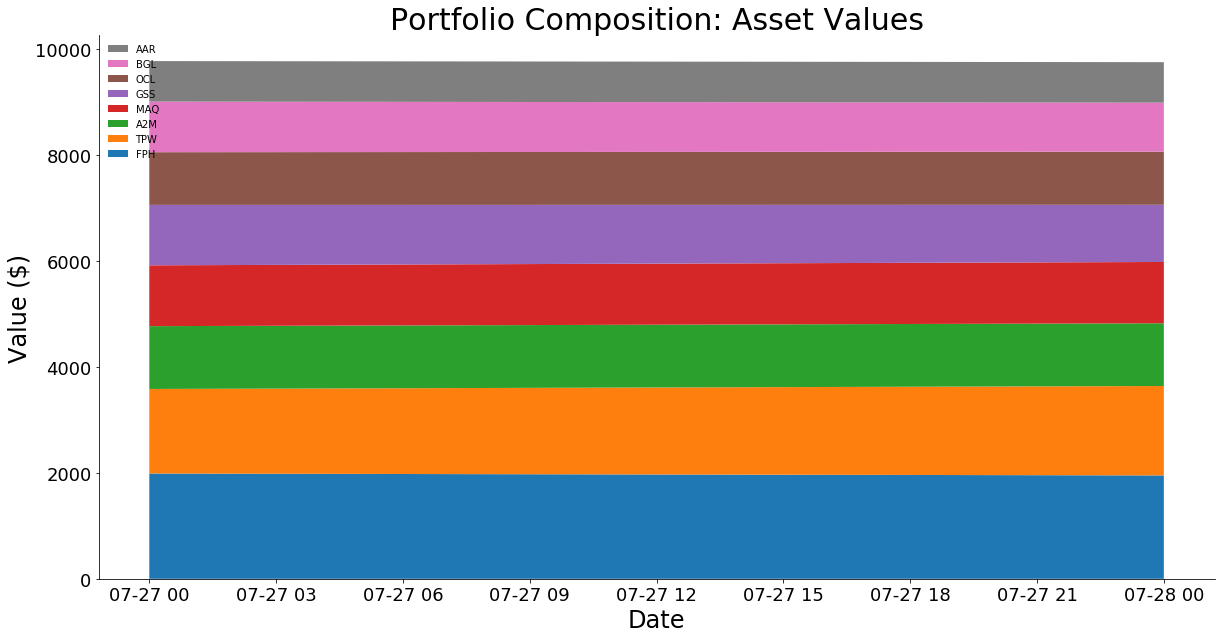

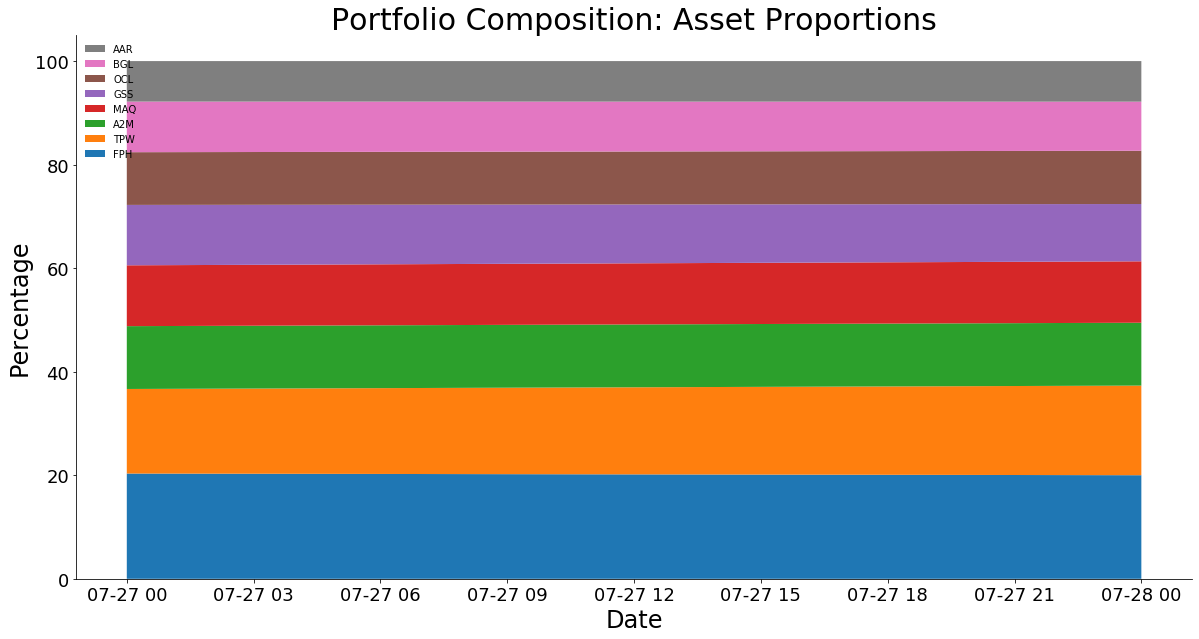

In [131]:
import os
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm # Not necessary to install - just does loading bars
from yahooquery import Ticker
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

TRADING_DAYS = 252
INTEREST_RATE = 0.02
TRADING_FEE = 19.95
# CODE: [Units, @ Price]
INVESTMENTS = {'BGL': [868, 1.065], 
               'OCL': [96, 10.36],
               'AAR': [4244, 0.175],
               'GSS': [404, 2.69],
               'MAQ': [25, 46.6],
               'A2M': [61, 19.5],
               'TPW': [205, 7.65],
               'FPH': [60, 32.85]}

# Include Fees in price
for code, data in INVESTMENTS.items():
    units, price = data
    new_price = (units*price + TRADING_FEE) / units
    INVESTMENTS[code].append(new_price)

SMALL, MED, LARGE = 18, 24, 30
LW = 2
plt.rc('xtick',labelsize=SMALL)
plt.rc('ytick',labelsize=SMALL)

# Try loading a dataframe of all daily data since start date for each asx code
START = '2020-07-27'

daily = pd.DataFrame({'date': []})

print('Load Data')
for code in tqdm(INVESTMENTS.keys()):
    try:
        df = Ticker(f'{code}.AX').history(start=START).reset_index()

        df = df[['date', 'close']]
        df.columns = ['date', code]
        daily = pd.merge(daily, df, on='date', how='outer').sort_values('date')
    except:
        print(f'History not found for: {code}', end=' ')

daily['date'] = pd.to_datetime(daily.date)
daily = daily.ffill().set_index('date')

original_investment = 0
for code, data in INVESTMENTS.items():
    units, price, fee_price = data
    original_investment += units * fee_price

units = [INVESTMENTS[code][0] for code in daily.columns]
portfolio_value = daily.to_numpy() @ units
profit = [-fees] + list(portfolio_value - original_investment)

################################################################
# Graph assets' performance
fig, ax = plt.subplots(figsize=(20, 10))
for code in daily:
    ax.plot(daily.index, daily[code]/daily[code].iloc[0], label=f'{code}', alpha=0.6)
    
ax.plot(daily.index, portfolio_value/portfolio_value[0], label='Portfolio', linestyle='--', lw=LW, c='black')
sns.despine()
ax.set_title('Portfolio and Asset Relative Performance', fontsize=LARGE)
ax.set_xlabel('Date', fontsize=MED)
ax.set_ylabel('Relative Value', fontsize=MED)
plt.legend(frameon=False, fontsize=16)
plt.show()

################################################################
# Graph Profit
fees = len(daily.columns) * TRADING_FEE
prev_date = daily.index[0] - pd.Timedelta(days=1)

fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

portfolio_value = np.array([original_investment-fees] + list(portfolio_value))
ax1.plot([prev_date] + list(daily.index), portfolio_value, alpha=0)
ax2.plot([prev_date] + list(daily.index), profit, lw=LW, c='green')

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.set_title('Portfolio Value/Profit', fontsize=LARGE)
ax1.set_xlabel('Date', fontsize=MED)
ax1.set_ylabel('Portfolio ($)', fontsize=MED)
ax2.set_ylabel('Profit ($)', fontsize=MED, rotation=270, labelpad=22)
plt.show()

################################################################
fig, ax = plt.subplots(figsize=(20, 10))

profits = np.diff(portfolio_value)
# Positive
ax.bar(daily.index, [max(0, p) for p in profits], width=1, color='green')

# Negative
ax.bar(daily.index, [min(0, p) for p in profits], width=1, color='red')

sns.despine()
ax.set_title('Daily Returns ($)', fontsize=LARGE)
ax.set_xlabel('Date', fontsize=MED)
ax.set_ylabel('Daily Return ($)', fontsize=MED)
plt.show()

################################################################
fig, ax = plt.subplots(figsize=(20, 10))

returns = 100 * np.diff(portfolio_value) / portfolio_value[:-1]
# Positive
ax.bar(daily.index, [max(0, r) for r in returns], width=1, color='green')

# Negative
ax.bar(daily.index, [min(0, r) for r in returns], width=1, color='red')

sns.despine()
ax.set_title('Daily Returns (%)', fontsize=LARGE)
ax.set_xlabel('Date', fontsize=MED)
ax.set_ylabel('Daily Return (%)', fontsize=MED)
plt.show()

################################################################
# Asset performance II
assets = daily * units
assets = assets.sort_values(axis=1, by=assets.index[-1], ascending=False)

fig, ax = plt.subplots(figsize=(20, 10))
ax.stackplot(daily.index, assets.to_numpy().T, labels=assets.columns)
handles, labels = ax.get_legend_handles_labels()

ax.set_title('Portfolio Composition: Asset Values', fontsize=LARGE)
ax.set_xlabel('Date', fontsize=MED)
ax.set_ylabel('Value ($)', fontsize=MED)
ax.legend(handles[::-1], labels[::-1], frameon=False, loc='upper left')
sns.despine()
plt.show()

################################################################
# Asset performance III
fig, ax = plt.subplots(figsize=(20, 10))
ax.stackplot(daily.index, 100 * assets.T / assets.T.sum(), labels=assets.columns)
handles, labels = ax.get_legend_handles_labels()

ax.set_title('Portfolio Composition: Asset Proportions', fontsize=LARGE)
ax.set_xlabel('Date', fontsize=MED)
ax.set_ylabel('Percentage', fontsize=MED)
ax.legend(handles[::-1], labels[::-1], frameon=False, loc='upper left')
sns.despine()
plt.show()